## Import necessary packages

In [3]:

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

# Prepare the data file

In [4]:
os.mkdir("train_test_val")
os.mkdir("train_test_val/train")
os.mkdir("train_test_val/test")
os.mkdir("train_test_val/val")

data=os.listdir("../archive (2)")
data.remove("README")
random.seed(5)
#train
rs=random.sample(data,32)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/train/{i}")
    data.remove(i)

#test
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/test/{i}")
    data.remove(i)

#valid
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/val/{i}")
    data.remove(i)

In [5]:
# os.mkdir("train_test_val")
# os.mkdir("train_test_val/train")
# os.mkdir("train_test_val/test")
# os.mkdir("train_test_val/val")

# for i in ["train","test","val"]:
#     for j in range(1,41):
#         os.mkdir(f"train_test_val/{i}/s{j}")
        
# for i in os.listdir("../archive (2)"):
#     if i == ".DS_Store":
#         continue
#     if i =="README":
#         continue
   
#     images=glob(f"../archive (2)/{i}/*.pgm")
   
#     #train
#     for img in random.sample(images, 6):
#         shutil.copyfile(img, f"train_test_val/train/{i}/{img.split('/')[-1]}")
#         images.remove(img)
       
#     #test
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/test/{i}/{img.split('/')[-1]}")
#         images.remove(img)
   
#     #val
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/val/{i}/{img.split('/')[-1]}")
#         images.remove(img)
   


## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [6]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 0.007
margin = 1.0
epochs = 15

## Initialize network variables

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("the device being used is:",device)

## Initialize network
model = SiameseNetwork()
model = model.to(device)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize loss
criterion = ContrastiveLoss(margin)

the device being used is: mps


## Create Datasets and Dataloaders

In [8]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(25),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/val',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Train the model

In [9]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(tqdm(train_dl, colour = 'GREEN',desc="Training  ",ncols=100)):
        optim.zero_grad()
        output1,output2 = model(input1.to(device),input2.to(device))        
        loss = criterion(output1,output2,target.to(device))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)    

    valid_epoch_loss = 0

    model.eval()

    for i,(input1,input2,target) in enumerate(tqdm(valid_dl, colour = 'GREEN',desc="Validating",ncols=100)):
        output1,output2 = model(input1.to(device),input2.to(device))
        loss = criterion(output1,output2,target.to(device))
        valid_epoch_loss += loss.item()

    valid_epoch_loss /= len(valid_ds)
    valid_loss.append(valid_epoch_loss)

    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    print("Validation loss :{}\n".format(valid_epoch_loss))

Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch [1/15] ----> Training loss :0.07766564711928367 

Validation loss :0.08894934356212617



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch [2/15] ----> Training loss :0.012089688796550035 

Validation loss :0.0055335089564323425



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch [3/15] ----> Training loss :0.007166545465588569 

Validation loss :0.006240061298012733



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch [4/15] ----> Training loss :0.004142414126545191 

Validation loss :0.0069782214239239694



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch [5/15] ----> Training loss :0.002822012931574136 

Validation loss :0.01825498417019844



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch [6/15] ----> Training loss :0.0021594731602817773 

Validation loss :0.006264972686767578



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch [7/15] ----> Training loss :0.0015704481862485408 

Validation loss :0.018593020364642145



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch [8/15] ----> Training loss :0.0010237180744297803 

Validation loss :0.011763349175453186



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch [9/15] ----> Training loss :0.0006545607495354489 

Validation loss :0.013818517327308655



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch [10/15] ----> Training loss :0.000568421429488808 

Validation loss :0.015292514860630036



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


Epoch [11/15] ----> Training loss :0.0006840218033175915 

Validation loss :0.01486649289727211



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Epoch [12/15] ----> Training loss :0.0007001614168984816 

Validation loss :0.012102668732404709



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch [13/15] ----> Training loss :0.00042844244599109514 

Validation loss :0.014944200962781906



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Epoch [14/15] ----> Training loss :0.00039949118145159445 

Validation loss :0.02084270492196083



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]

Epoch [15/15] ----> Training loss :0.0002983830461744219 

Validation loss :0.010885260254144668



## Plot losses

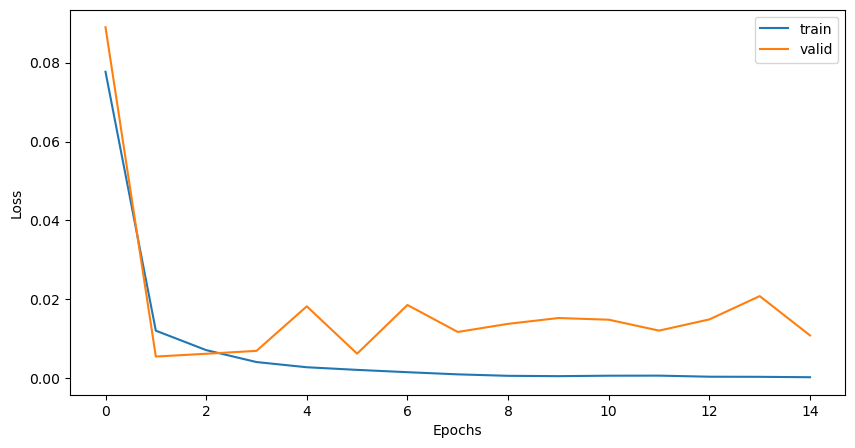

In [10]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

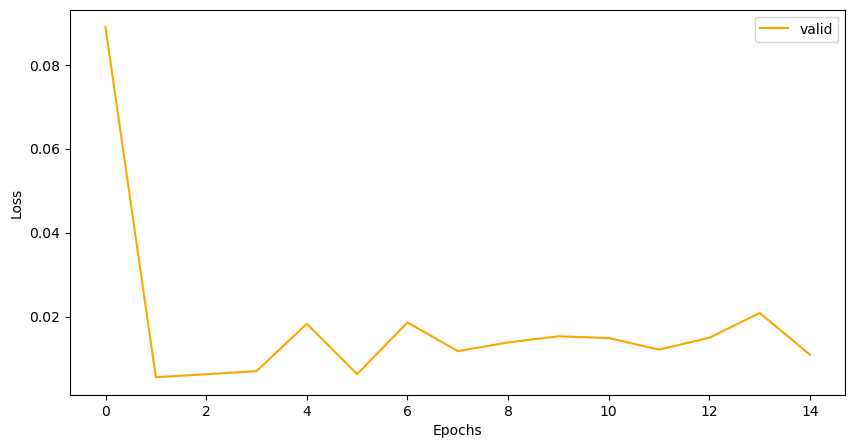

In [11]:
plt.figure(figsize = (10,5))
plt.plot(valid_loss,label = 'valid',color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

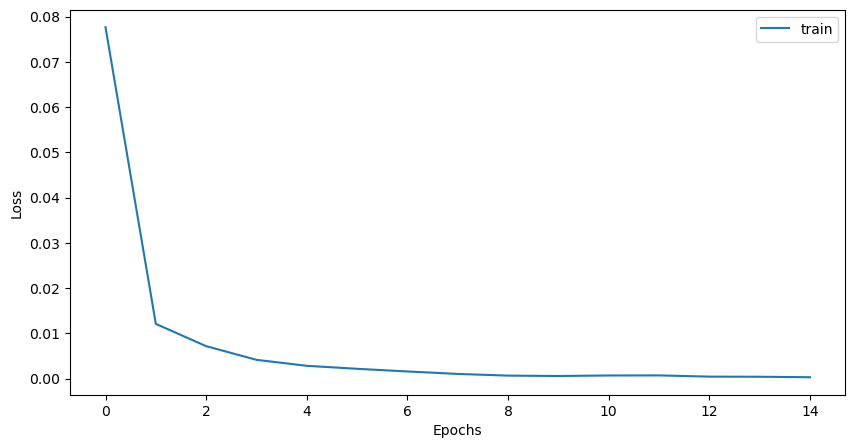

In [12]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [13]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

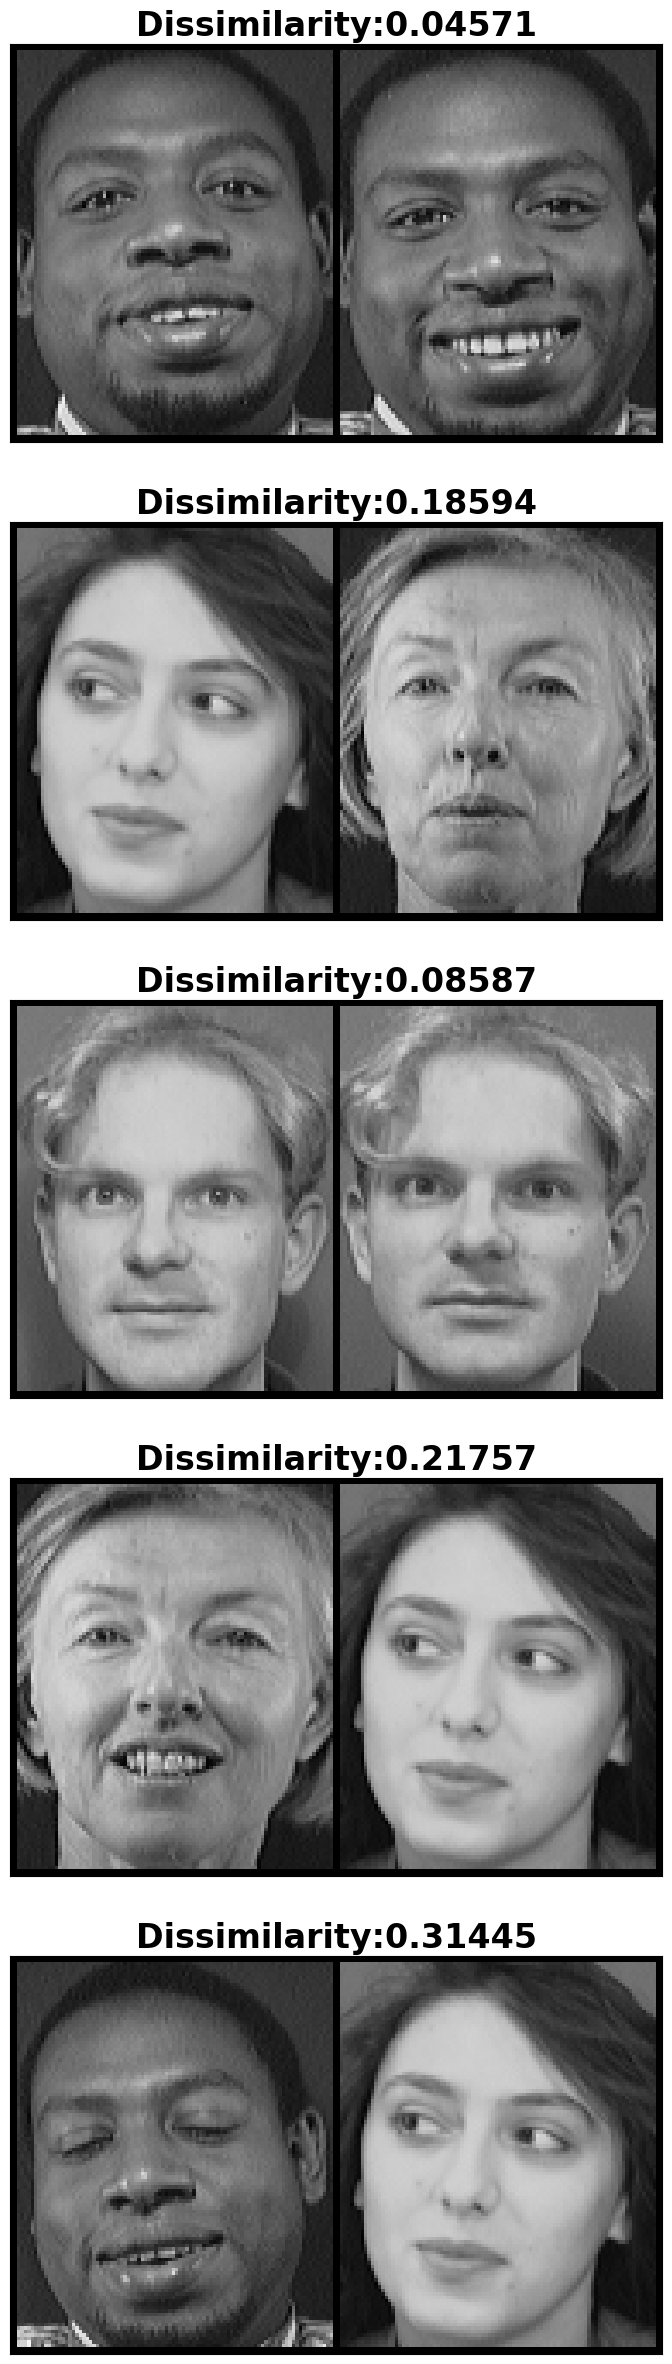

In [263]:
invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0.],
                                                     std = [ 1/0.5]),
                                torchvision.transforms.Normalize(mean = [ -0.5],
                                                     std = [ 1.]),
                               ])

fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(test_ds))
    input1,input2,target = test_ds[idx]
    model=model.to(device)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    input1=invTrans(input1)
    input2=invTrans(input2)
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)

    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [87]:
threshold=0.15

In [88]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       139
           1       1.00      0.93      0.97       181

    accuracy                           0.96       320
   macro avg       0.96      0.97      0.96       320
weighted avg       0.97      0.96      0.96       320



In [258]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.86      1.00      0.93        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.92        40



In [256]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.76      1.00      0.86        16

    accuracy                           0.88        40
   macro avg       0.88      0.90      0.87        40
weighted avg       0.90      0.88      0.88        40



## Save the trained model for future usage

In [20]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [21]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(